<div class="alert alert-warning">
<h1>Advanced Statistical Inference - Assessed Exercise</h1>
<h2>Daniele Reda</h2>
</div>

<h3>Note on color codings</h3>
<div class="label label-warning">Yellow</div> is used for titles and subtitles
<div class="label label-default">Transparent</div> is used for formulas, explanations and informations
<div class="label label-info">Blue</div> is used to write the questions asked by the assessed exercise
<div class="label label-success">Green</div> is used for the answers to the questions
<div class="label label-danger">Red</div> is for to-dos (hopefully you shouldn't see any of these)

<h3>Introduction and Instruction</h3>
<br>
In this work you will analyze the MNIST and CIFAR10 datasets available to download from:
<br>
<ul>
<li>http://yann.lecun.com/exdb/mnist/
<li>https://www.cs.toronto.edu/~kriz/cifar.html
</ul>
<br>
Listed below are various exercises to undertake.

<div class="alert alert-info">
Download the MNIST and CIFAR10 datasets and import them.
</div>

In [37]:
from keras.datasets import mnist, cifar10

(mnist_train_data, mnist_train_label), (mnist_test_data, mnist_test_label) = mnist.load_data()
(cifar10_train_data, cifar10_train_label), (cifar10_test_data, cifar10_test_label) = cifar10.load_data()

<div class="alert alert-info">
Comment on the distribution of class labels and the dimensionality of the input and how these may affect the analysis.
</div>

In [2]:
import os
import sys
import re
import random
import functools

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from time import time

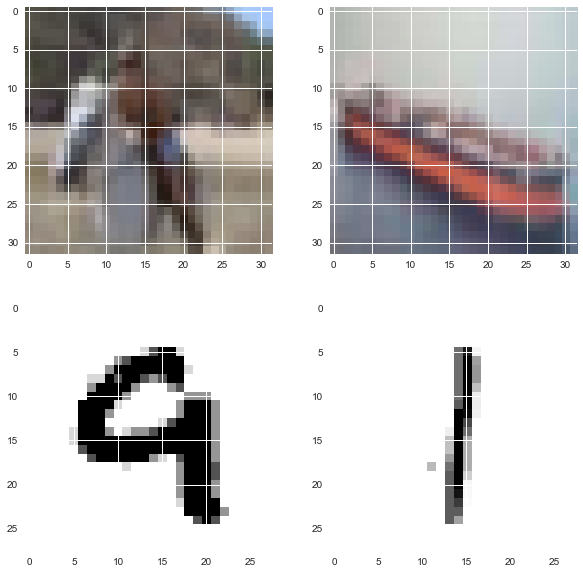

In [3]:
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(cifar10_test_data[np.random.randint(0, len(cifar10_test_data))])
plt.subplot(222)
plt.imshow(cifar10_test_data[np.random.randint(0, len(cifar10_test_data))])
plt.subplot(223)
plt.imshow(mnist_test_data[np.random.randint(0, len(mnist_test_data))])
plt.subplot(224)
plt.imshow(mnist_test_data[np.random.randint(0, len(mnist_test_data))])
plt.show()

<div class="alert alert-danger">
TODO comment figures, plot distribution of labels
</div>

<div class="alert alert-warning">
<h3>Classification</h3>
</div>

<div class="alert alert-info">
Implement the Naïve Bayes classifier.
</div>

The naïve Bayes classifier is a very simple probabilistic classifier based on Bayes rule:
<br><br>
\begin{equation}
P(\ t_{new}=k \ \vert \ \mathbf{X},\mathbf{t},\mathbf{x}_{new}\ )
= \frac {P(\ \mathbf{x}_{new} \ \vert \ t_{new}=k, \mathbf{X},\mathbf{t} \ ) \ P( \ t_{new}=k \ )}
        {\sum_jP(\ \mathbf{x}_{new} \ \vert \ t_{new} = j, \mathbf{X},\mathbf{t} \ ) \ P( \ t_{new}=k \ )}
\end{equation}
<br><br>
given that:
<ul>
<li>$\mathbf{X}$ is the data of our training set
<li>$\mathbf{t}$ are the labels of our training set
<li>$\mathbf{x}_{new}$ is the sample we want to classify
<li>$t_{new}$ is the class of our sample we want to evaluate
</ul>
<br>
We define the elements of the Bayes rule as:
<ul>
<li><b>Posterior</b>: $P(\ t_{new}=k \ \vert \ \mathbf{X},\mathbf{t},\mathbf{x}_{new}\ )$
<ul><li>It's the probability of $\mathbf{x}_{new}$ belonging to class $k$ given the training set $\mathbf{X}$ and its labels $\mathbf{t}$</ul>
<li><b>Likelihood</b>: $P(\ \mathbf{x}_{new} \ \vert \ t_{new}=k, \mathbf{X},\mathbf{t} \ )$
<ul><li>It is a density (<b>not</b> a probability) telling how likely it is that, given that the label of the element is $k$, we are able to see an element like $\mathbf{x}_{new}$</ul>
<li><b>Prior</b>: $P( \ t_{new}=k \ )$
<ul><li>It is the probability of finding the label $k$ without any observations on the data.</ul>
<li><b>Marginal likelihood</b>: $\sum_jP(\ \mathbf{x}_{new} \ \vert \ t_{new} = j, \mathbf{X},\mathbf{t} \ ) \ P( \ t_{new}=k \ )$
<ul><li>Normalisation constant.</ul>
</ul>
<br>
The <i>likelihood</i> for a label $k$ is defined as:
\begin{equation}
\prod\limits_{d=1}^{K}\mathcal{N}(\mu_{kd}, \ \sigma^2_{kd})
\end{equation}
where $\mu_{kd}$ and $\sigma^2_{kd}$ are:
\begin{align*}
\mu_{kd} =& \ \frac{1}{N_k} \ \sum\limits_{n:t_n=k} x_{nd} \\
\sigma^2_{kd} =& \ \frac{1}{N_k} \ \sum\limits_{n:t_n=k} (x_{nd} - \mu_{kd})^2
\end{align*}
<br>
and so it becomes, for mnist, a product of 784 gaussians. <i>Why 784?</i> Because mnist images are 28x28 and when we flat the matrix we get a vector of 784 elements and we have to build a gaussian for each pixel that represents the distribution of the color of that pixel for that label. The same happens for cifar where each image is a 32x32 matrix with 3 channels and so it gets fatten into a 32x32x3=3072 numpy array.
<br><br>
The <i>prior</i> for a label $k$ is defined as:
\begin{equation}
\frac{nr. \ of \ elements \ of \ label \ k}{total \ nr. \ of \ elements}
\end{equation}
<br><br>
Below is the code for computing naïve Bayes.

In [58]:
def get_prior(data, size):
    return len(data)/size
    
def get_means_and_variances(data):
    return (np.array(data).mean(axis=0), np.array(data).var(axis=0)+1e-3)

def get_likelihood(means, variances, sample):
    return np.prod(np.float128(np.exp(-(sample-means)/(2*variances)) / np.sqrt(2*np.pi*variances)))

def get_marginal_likelihood(likelihoods, priors):
    return np.sum([x*y for x,y in zip(likelihoods, priors)])

def get_posterior(likelihood, prior, marginal_likelihood):
    #print(likelihood, prior, marginal_likelihood)
    return likelihood*prior/marginal_likelihood

def predict(data, labels, samples, norm=None, mnist=True):
    train_size = len(data)
    test_size = len(samples)
        
    data = data.reshape(train_size, -1)
    samples = samples.reshape(test_size, -1)

    if norm:
        data = data/norm
        samples = samples/norm
        
    dict_per_label = {k:[] for k in np.unique(labels)}
    for _ in np.arange(train_size):
        if mnist is True:
            dict_per_label[labels[_]].append(data[_])
        else:
            dict_per_label[labels[_][0]].append(data[_])
                
    priors = [get_prior(dict_per_label[k], train_size) for k in np.unique(labels)]
    #print priors
    
    means_and_variances = [get_means_and_variances(dict_per_label[k]) for k in np.unique(labels)]
    predictions = []
    t1 = time.time()
    for sample in samples:
        likelihoods = [get_likelihood(_[0], _[1], sample) for _ in means_and_variances]
        #marginal_likelihood = get_marginal_likelihood(likelihoods, priors)
        probabilities_k = [get_posterior(likelihoods[k], priors[k], 1) for k in np.unique(labels)]
        #print(probabilities_k)
        predictions.append(np.argmax(probabilities_k))
    print(time.time()-t1)   
    return predictions

<div class="alert alert-info">
Describe a positive and a negative feature of the classifier for these tasks.
</div>

<div class="alert alert-info">
Describe any data pre-processing that you suggest for this data and your classifier.
</div>

<div class="alert alert-danger">
TODO explain zero frequency problem (why we summed one everywhere)
</div>

<div class="alert alert-info">
Describe a positive and a negative feature of the classifier for these tasks.
</div>

<div class="alert alert-info">
Apply your classifier to the two given datasets.
<br>
Make sure your optimization is clearly commented.
<br>
Use classification accuracy and test log-likelihood as your figures of merit.
</div>

In [59]:
import time
t1 = time.time()
predictions = predict(mnist_train_data, mnist_train_label, mnist_test_data, norm=255)
print("Time for Mnist: ", time.time()-t1)
correct = 0
for k in np.arange(len(mnist_test_data)):
    if predictions[k] == mnist_test_label[k]:
        correct += 1
print("Accuracy: " + str(correct/100) + "%")

20.090957164764404
Time for Mnist:  21.819724798202515
Accuracy: 71.5%


In [ ]:
predict(mnist_train_data, mnist_train_label, mnist_test_data[3:4], norm=255)

In [44]:
import time
t1 = time.time()
predictions = predict(cifar10_train_data, cifar10_train_label, cifar10_test_data, mnist=False, norm=255)
print("Time for Cifar: ", time.time()-t1)
correct = 0
for k in np.arange(len(cifar10_test_data)):
    if predictions[k] == cifar10_test_label[k]:
        correct += 1
print("Accuracy: " + str(correct/100) + "%")

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in longdouble_scalars
  from ipykernel import kernelapp as app


Time for Cifar:  28.685863971710205
Accuracy: 10.01%


In [48]:
predict(cifar10_train_data, cifar10_train_label, cifar10_test_data[2000:2001], mnist=False, norm=255)

2.87414071607e+3234 0.1 2.87414071607e+3233
4.09302696499e+1853 0.1 2.87414071607e+3233
1.99359734696e+2588 0.1 2.87414071607e+3233
2.03263817938e+1984 0.1 2.87414071607e+3233
8.33503780848e+2656 0.1 2.87414071607e+3233
2.2935869539e+2207 0.1 2.87414071607e+3233
4.6564869307e+2119 0.1 2.87414071607e+3233
6.07504096523e+2377 0.1 2.87414071607e+3233
1.61387391097e+3168 0.1 2.87414071607e+3233
1.69228915681e+2262 0.1 2.87414071607e+3233


[0]

<div class="alert alert-info">
Display the confusion matrix on the test data.
</div>

<div class="alert alert-info">
Discuss the performance, compare them against a classifier that outputs random class labels, and suggest ways in which performance could be improved.
</div>

<div class="alert alert-warning">
<h3>Linear Regression</h3>
</div>

<div class="alert alert-info">
Implement Bayesian linear regression.
</div>

<div class="alert alert-info">
Treat class labels as continuous and apply regression to the training data.
</div>

<div class="alert alert-info">
Produce a scatter plot showing the predictions versus the true targets for the test set and compute the m  ean squared error on the test set.
</div>

<div class="alert alert-info">
Suggest a way to discretize predictions and display the confusion matrix on the test data and report accuracy.
</div>

<div class="alert alert-info">
Discuss regression performance with respect to classification performance.
</div>

<div class="alert alert-info">
Describe one limitation of using regression for this particular task.
</div>

<div class="alert alert-warning">
<h3>Bonus question</h3>
</div>

<div class="alert alert-info">
The state-of-the-art in these image classification problems suggests that convolutional layers in convolutional neural networks yield most of the improvements compared to standard neural networks. The reason is that they are capable of modeling spatial patterns through the hierarchical analysis of patches of images. Propose and implement ways to exploit patch information in the Naïve Bayes classifier or linear regression. A couple of suggestions are: (i) apply Naïve Bayes classification to the output of convolutional layer in the LeNet architecture (ii) construct the Naïve Bayes classifier by calculating patch-specific statistics and extend this by stacking multiple of these
</div>